# Importing the dataset

In [1]:
import pandas as pd

df = pd.read_csv("C:\\Users\\KIIT\\OneDrive\\Desktop\\Multilabel\\enron.csv")

df.head()

,A.A8,C.C9,B.B12,C.C11,C.C5,C.C7,B.B2,B.B3,D.D16,A.A7,...,workers,working,world,writer,writers,www,year,years,yesterday,york
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Visualizing the label distribution


<AxesSubplot:>

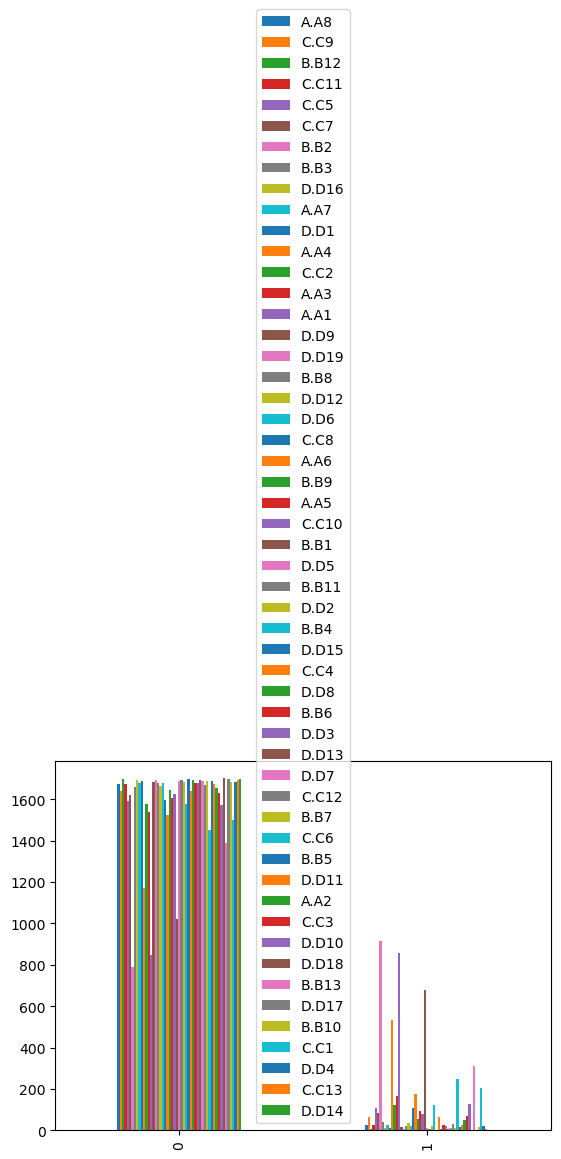

In [2]:
df1 = df[df.columns[0:53]]
df2 = df1.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")

# MLSMOTE

In [3]:
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

def get_tail_label(data: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = data.sum(axis=0)
    irlbl = irlbl[(irlbl > np.quantile(irlbl,ql[0])) & ((irlbl < np.quantile(irlbl,ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = np.median(irlbl)
    tail_label = pd.Series(irlbl)[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    y_df = pd.DataFrame(y)
    X_df = pd.DataFrame(X)
    tail_labels = get_tail_label(y_df, ql=ql)
    index = y_df[y_df[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X_df[X_df.index.isin(index)].reset_index(drop = True)
    y_sub = y_df[y_df.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

# Preparing training DataFrame

In [4]:
from sklearn.model_selection import train_test_split

X_df = df[df.columns[53:]]
y_df = df[df.columns[0:53]]

X = np.asarray(X_df)
y = np.asarray(y_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Oversampling using MLSMOTE

In [6]:
X_traindf = pd.DataFrame(X_train)
y_traindf = pd.DataFrame(y_train)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
df_train = pd.concat([y_traindf,X_traindf], axis=1)
df_train.columns = range(df_train.shape[1])
df_train.T.reset_index(drop=True).T

X_sub, y_sub = get_minority_samples(X_train, y_train) # Getting minority samples of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 840, 5)  # Applying MLSMOTE to augment the dataframe

df_temp = pd.concat([y_res, X_res], axis=1)
df_temp.columns = range(df_temp.shape[1])
df_temp.T.reset_index(drop=True).T

df_train.reset_index(drop=True, inplace=True)
df_temp.reset_index(drop=True, inplace=True)
df_train = pd.concat([df_train, df_temp])

X_new = df_train[df_train.columns[53:]]
y_new = df_train[df_train.columns[0:53]]

X_newtrain = np.asarray(X_new)
y_newtrain = np.asarray(y_new)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Visualizing the resampled training labels

<AxesSubplot:>

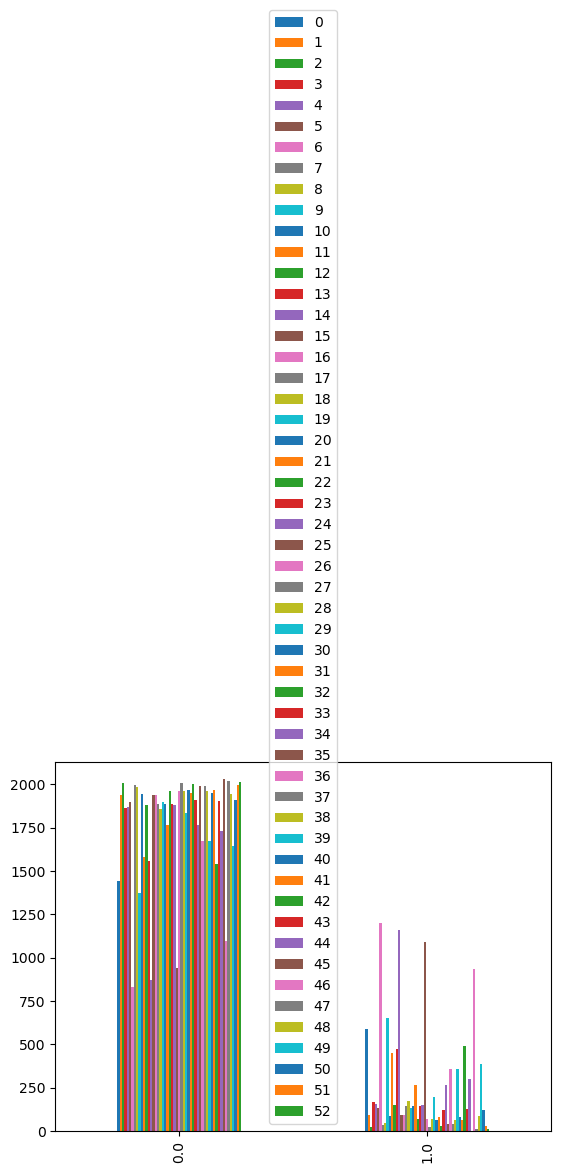

In [8]:
df2 = y_new.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")

# Binary Relevance

 without using cost sensitive approach

In [23]:
import sklearn.metrics as metrics
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.tree import DecisionTreeClassifier


classifier1 = BinaryRelevance(
    classifier = DecisionTreeClassifier(random_state=0),
    require_dense = [False, True]
)

# train
classifier1.fit(X_train, y_train)

# predict
predictions1 = classifier1.predict(X_test)

In [21]:
import sklearn.metrics as metrics
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier


classifier1 = BinaryRelevance(
    classifier = RandomForestClassifier(n_estimators=10),
    require_dense = [False, True]
)

# train
classifier1.fit(X_train, y_train)

# predict
predictions1 = classifier1.predict(X_test)

using cost sensitive approach

In [24]:
import sklearn.metrics as metrics
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.tree import DecisionTreeClassifier


classifier2 = BinaryRelevance(
    classifier = DecisionTreeClassifier(random_state=0, class_weight = "balanced"),
    require_dense = [False, True]
)

# train
classifier2.fit(X_newtrain, y_newtrain)

# predict
predictions2 = classifier2.predict(X_test)

In [20]:
import sklearn.metrics as metrics
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier


classifier1 = BinaryRelevance(
    classifier = RandomForestClassifier(n_estimators=10, class_weight="balanced"),
    require_dense = [False, True]
)

# train
classifier2.fit(X_train, y_train)

# predict
predictions2 = classifier2.predict(X_test)

# Classification Report

In [25]:
from sklearn.metrics import classification_report
from prettytable import PrettyTable
from sklearn.metrics import average_precision_score



report1 = classification_report(y_test, predictions1, output_dict=True)
report2 = classification_report(y_test, predictions2, output_dict=True)

table1 = PrettyTable(['Label', 'Precision', 'Recall', 'F1-Score'])
table2 = PrettyTable(['Label', 'Precision', 'Recall', 'F1-Score'])
for label in range(0,53):
    precision1 = report1[str(label)]['precision']
    recall1 = report1[str(label)]['recall']
    f1_score1 = report1[str(label)]['f1-score']
    precision = report2[str(label)]['precision']
    recall = report2[str(label)]['recall']
    f1_score = report2[str(label)]['f1-score']
    table1.add_row([label, precision1, recall1, f1_score1])
    table2.add_row([label, precision, recall, f1_score])


prec1 = metrics.precision_score(y_test, predictions1, average='macro')
rec1 = metrics.recall_score(y_test, predictions1, average='macro')
f1score1 = metrics.f1_score(y_test, predictions1, average='macro')

table1.add_row(['Macro avg', prec1, rec1, f1score1])

prec1 = metrics.precision_score(y_test, predictions1, average='micro')
rec1 = metrics.recall_score(y_test, predictions1, average='micro')
f1score1 = metrics.f1_score(y_test, predictions1, average='micro')

table1.add_row(['Micro avg', prec1, rec1, f1score1])

prec1 = metrics.precision_score(y_test, predictions1, average='weighted')
rec1 = metrics.recall_score(y_test, predictions1, average='weighted')
f1score1 = metrics.f1_score(y_test, predictions1, average='weighted')

table1.add_row(['Weighted avg', prec1, rec1, f1score1])

prec1 = metrics.precision_score(y_test, predictions1, average='samples')
rec1 = metrics.recall_score(y_test, predictions1, average='samples')
f1score1 = metrics.f1_score(y_test, predictions1, average='samples')

table1.add_row(['Samples avg', prec1, rec1, f1score1])

prec2 = metrics.precision_score(y_test, predictions2, average='macro')
rec2 = metrics.recall_score(y_test, predictions2, average='macro')
f1score2 = metrics.f1_score(y_test, predictions2, average='macro')

table2.add_row(['Macro avg', prec2, rec2, f1score2])

prec2 = metrics.precision_score(y_test, predictions2, average='micro')
rec2 = metrics.recall_score(y_test, predictions2, average='micro')
f1score2 = metrics.f1_score(y_test, predictions2, average='micro')

table2.add_row(['Micro avg', prec2, rec2, f1score2])

prec2 = metrics.precision_score(y_test, predictions2, average='weighted')
rec2 = metrics.recall_score(y_test, predictions2, average='weighted')
f1score2 = metrics.f1_score(y_test, predictions2, average='weighted')

table2.add_row(['Weighted avg', prec2, rec2, f1score2])

prec2 = metrics.precision_score(y_test, predictions2, average='samples')
rec2 = metrics.recall_score(y_test, predictions2, average='samples')
f1score2 = metrics.f1_score(y_test, predictions2, average='samples')

table2.add_row(['Samples avg', prec2, rec2, f1score2])

print("Performance before Oversampling : ")
print(table1)
print()
print("Performance after Oversampling : ")
print(table2)

Performance before Oversampling : 
+--------------+---------------------+---------------------+---------------------+
|    Label     |      Precision      |        Recall       |       F1-Score      |
+--------------+---------------------+---------------------+---------------------+
|      0       |         0.12        |  0.3333333333333333 |  0.1764705882352941 |
|      1       |        0.0625       | 0.06666666666666667 | 0.06451612903225808 |
|      2       |         0.0         |         0.0         |         0.0         |
|      3       |        0.0625       |        0.125        | 0.08333333333333333 |
|      4       | 0.18181818181818182 | 0.21428571428571427 | 0.19672131147540986 |
|      5       |  0.2962962962962963 | 0.36363636363636365 | 0.32653061224489793 |
|      6       |  0.7442748091603053 |  0.6794425087108014 |  0.7103825136612022 |
|      7       | 0.15789473684210525 |         0.2         | 0.17647058823529413 |
|      8       | 0.14285714285714285 |  0.3333333333

C:\Users\KIIT\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KII